In [1]:
using QuantumOptics
using IonSim
import PyPlot

include("./single_qubit_chamber.jl")
using .SingleQubitChamber: construct_single_qubit_chamber, RX, RY, RZ
const plt = PyPlot;

In [2]:
# Run this cell to test if the LinearChain object is gonna give us a headache.

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.594650 seconds (14.53 M allocations: 935.068 MiB, 4.96% gc time, 99.86% compilation time)


Globals

In [3]:
using .SingleQubitChamber: CALCIUM40 
TIMESCALE = 1e-6 
TRAP_FREQUENCY = 1e6
B_STRENGTH = 4e-4
PI_TIME = 2e-6;

More globals

In [4]:
@time chain = LinearChain(
        ions = [CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = TRAP_FREQUENCY), 
        selectedmodes = (;z = [1],)
    )

laser = Laser(Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
chamber = Chamber(iontrap=chain, B=B_STRENGTH, Bhat=ẑ, δB=0, lasers=[laser]);

WAVELENGTH = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(laser, WAVELENGTH)

INTENSITY = intensity_from_pitime(laser, PI_TIME, CALCIUM40, ("S", "D"), chamber);

VIB_MODE =  modes(chamber)[1]
ψ0_MOTIONAL = VIB_MODE[0] # GLOBAL: ground state of the first vibrational mode

chain = Nothing
laser = Nothing
chamber = Nothing;

  0.032765 seconds (87.55 k allocations: 5.331 MiB, 93.59% compilation time)


Helper function for plotting

In [5]:
function plot_populations(chamber, tout, sol)
    vibrational_mode = modes(chamber)[1]

    Z_plus = CALCIUM40["S"]
    Z_minus = CALCIUM40["D"]

    X_plus = (Z_plus + Z_minus)/√2
    X_minus = (Z_plus - Z_minus)/√2

    Y_plus = (Z_plus + im*Z_minus)/√2
    Y_minus = (Z_plus - im*Z_minus)/√2

    prob_X_plus = expect(dm(X_plus) ⊗ one(vibrational_mode), sol)
    prob_X_minus = expect(dm(X_minus) ⊗ one(vibrational_mode), sol)
    prob_Y_plus = expect(dm(Y_plus) ⊗ one(vibrational_mode), sol)
    prob_Y_minus = expect(dm(Y_minus) ⊗ one(vibrational_mode), sol)
    prob_Z_plus = expect(dm(Z_plus) ⊗ one(vibrational_mode), sol)
    prob_Z_minus = expect(dm(Z_minus) ⊗ one(vibrational_mode), sol)

    fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
    x_ax.plot(tout, prob_X_plus, label="|X+⟩", linewidth=4)
    x_ax.plot(tout, prob_X_minus, "--", label="|X-⟩", linewidth=4)
    x_ax.set_xlim(tout[1], tout[end])
    x_ax.set_ylim(0, 1)
    x_ax.legend(loc=1)
    x_ax.set_xlabel("Time (μs)")

    y_ax.plot(tout, prob_Y_plus, label="|Y+⟩", linewidth=4)
    y_ax.plot(tout, prob_Y_minus, "--", label="|Y-⟩", linewidth=4)
    y_ax.set_xlim(tout[1], tout[end])
    y_ax.set_ylim(0, 1)
    y_ax.legend(loc=1)
    y_ax.set_xlabel("Time (μs)")

    z_ax.plot(tout, prob_Z_plus, label="|Z+⟩", linewidth=4)
    z_ax.plot(tout, prob_Z_minus, "--", label="|Z-⟩", linewidth=4)
    z_ax.set_xlim(tout[1], tout[end])
    z_ax.set_ylim(0, 1)
    z_ax.legend(loc=1)
    z_ax.set_xlabel("Time (μs)")

    return fig
end

plot_populations (generic function with 1 method)

## 1. Simulate $R_X$ rotations

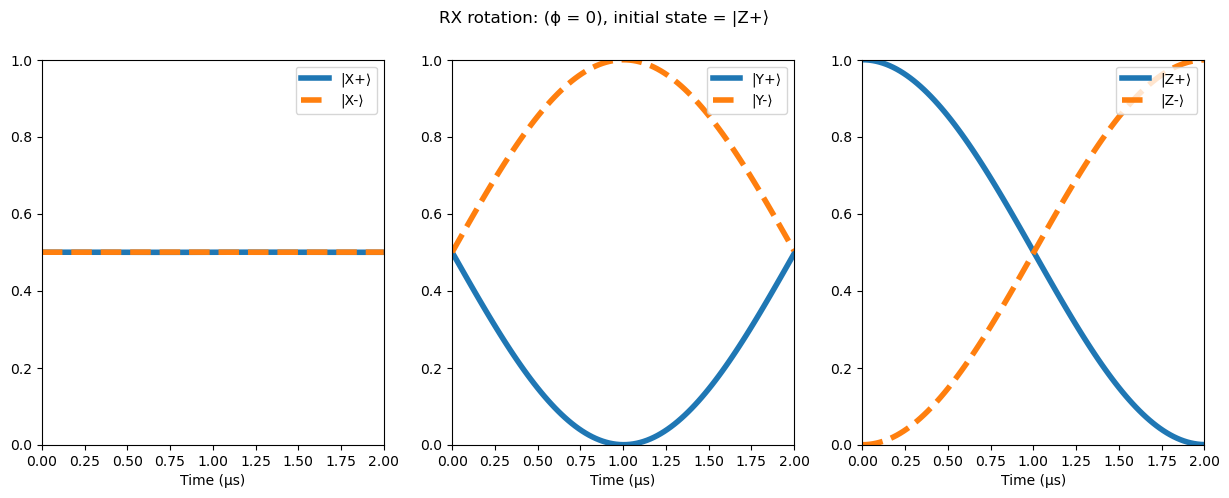

In [7]:
chamber = construct_single_qubit_chamber( 
    TRAP_FREQUENCY,
    INTENSITY,
    WAVELENGTH,
    PI_TIME,
    B_STRENGTH
)

# Initial state
ψ0_electronic = CALCIUM40["S"]
ψ0 = ψ0_electronic ⊗ ψ0_MOTIONAL# GLOBAL: initial state for all the simulations

# RX(2π)
tout, ψt = RX(π, chamber, ψ0, PI_TIME, TIMESCALE)

fig = plot_populations(chamber, tout, ψt)
fig.suptitle("RX rotation: (ϕ = 0), initial state = |Z+⟩")
plt.display(fig)

## 2. Simulate $R_Y$ rotations

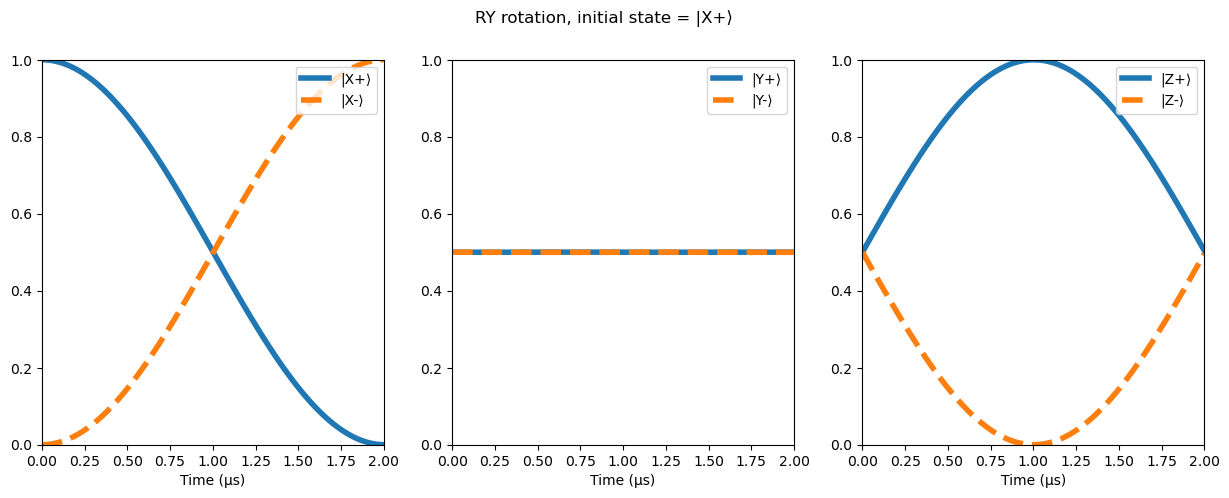

In [8]:
# Initial state
ψ0_electronic = (CALCIUM40["S"] + CALCIUM40["D"])/√2
ψ0 = ψ0_electronic ⊗ ψ0_MOTIONAL # GLOBAL: initial state for all the simulations

# RX(2π)
tout, ψt = RY(π, chamber, ψ0, PI_TIME, TIMESCALE)

fig = plot_populations(chamber, tout, ψt)
fig.suptitle("RY rotation, initial state = |X+⟩")
plt.display(fig)

## 3. Simulate $R_Z$ rotations

$R_Z(\theta) = R_X(\frac{\pi}{2}) R_Y(\theta) R_X(-\pi/2)$

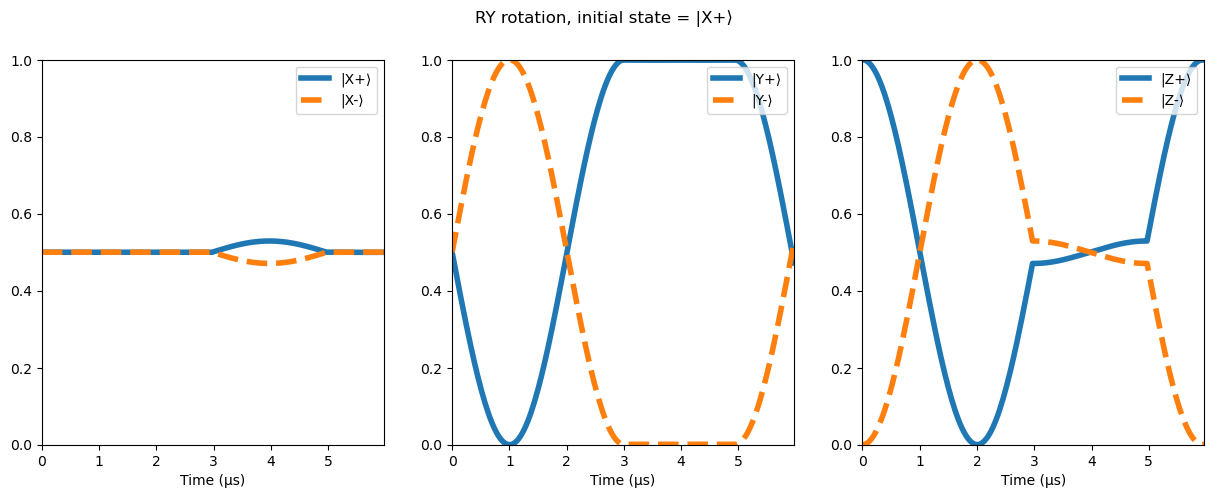

In [51]:
# Initial state
#ψ0_electronic = CALCIUM40["S"]
ψ0_electronic = (CALCIUM40["S"] + CALCIUM40["D"])/√2
ψ0 = ψ0_electronic ⊗ ψ0_MOTIONAL # GLOBAL: initial state for all the simulations

# RX(2π)
tout, ψt = RZ(π, chamber, ψ0, PI_TIME, TIMESCALE)

fig = plot_populations(chamber, tout, ψt)
fig.suptitle("RY rotation, initial state = |X+⟩")
plt.display(fig)